In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

Метод Гаусса с выбором ведущего элемента

In [ ]:
def gauss_solve(a, b):
    n = len(a)
    for i in range(n):
        max_row = i
        for j in range(i + 1, n):
            if abs(a[j][i]) > abs(a[max_row][i]):
                max_row = j
        if max_row != i:
            a[[i, max_row], :] = a[[max_row, i], :]
            b[i], b[max_row] = b[max_row], b[i]
        for j in range(i + 1, n):
            c = a[j, i] / a[i, i]
            a[j] -= c * a[i]
            b[j] -= c * b[i]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - np.dot(a[i, i + 1:], x[i + 1:])) / a[i, i]
    return x

Класс для хранения разреженных матриц, а также для их LU-разложения

In [ ]:
class MatrixCSR:
    def __init__(self, matrix):
        values = []
        col_indices = []
        row_offsets = [0]

        for i in range(matrix.shape[0]):
            nnz_in_row = 0
            for j in range(matrix.shape[1]):
                if matrix[i, j] != 0:
                    values.append(matrix[i, j])
                    col_indices.append(j)
                    nnz_in_row += 1
            row_offsets.append(row_offsets[-1] + nnz_in_row)

        self.values = np.array(values)
        self.col_indices = np.array(col_indices)
        self.row_offsets = np.array(row_offsets)
        self.shape = matrix.shape

    def __getitem__(self, ij):
        i, j = ij
        for k in range(self.row_offsets[i], self.row_offsets[i + 1]):
            if self.col_indices[k] == j:
                return self.values[k]
        return 0

    def get_row(self, i):
        row = np.zeros(self.shape[1])
        for k in range(self.row_offsets[i], self.row_offsets[i + 1]):
            row[self.col_indices[k]] = self.values[k]
        return row

    def get_column(self, j):
        column = np.zeros(self.shape[0])
        for i in range(self.shape[0]):
            for k in range(self.row_offsets[i], self.row_offsets[i + 1]):
                if self.col_indices[k] == j:
                    column[i] = self.values[k]
        return column

    def toarray(self):
        return np.array([self.get_row(i) for i in range(self.shape[0])])

    def lu(self):
        n = self.shape[0]

        L = np.zeros((n, n))
        U = self.toarray()

        for i in range(n):
            for j in range(i + 1, n):
                coef = U[j, i] / U[i, i]
                L[j, i] = coef
                U[j, i:] -= U[i, i:] * coef
            L[i, i] = 1

        return L, U


A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 19]])
A = MatrixCSR(A)
print(A.lu())

(array([[1., 0., 0.],
       [4., 1., 0.],
       [7., 2., 1.]]), array([[ 1.,  2.,  3.],
       [ 0., -3., -6.],
       [ 0.,  0., 10.]]))


Решение СЛАУ с использованием LU-разложения

In [ ]:
def lu_solve(l, u, b):

    n = len(b)
    y = np.zeros(n)
    x = np.zeros(n)

    y[0] = b[0] / l[0, 0]
    for i in range(1, n):
        y[i] = (b[i] - np.dot(l[i, :i], y[:i])) / l[i, i]

    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(u[i, i + 1:], x[i + 1:])) / u[i, i]

    return x

Метод Зейделя

In [ ]:
def seidel_solve(a, b, eps=1e-6, max_iter=1000):
    n = a.shape[0]
    x = np.zeros(n)
    norm_diff = eps + 1
    iter_num = 0
    norm = 0

    while norm_diff > eps and iter_num < max_iter:
        norm_prev = norm
        for i in range(n):
            s1 = np.dot(a[i, :i], x[:i])
            s2 = np.dot(a[i, i+1:], x[i+1:])
            x[i] = (b[i] - s1 - s2) / a[i, i]
        norm = np.linalg.norm(x)
        norm_diff = abs(norm - norm_prev)
        iter_num += 1

    if iter_num == max_iter:
        print(f'Метод Зейделя не сошелся за {max_iter} итераций')

    return x, iter_num

Метод для генерации матриц из условия лабораторной работы
Если делать слабое диагональное преобладание как в условии, то начиная с k = 13 метод Гаусса выдаёт неправильные результаты сильно отличающиеся от ожидаемых, например:
 **[ 2.5349,  3.5349,  4.5349,  5.5349,  6.5349,  7.5349,
  8.5349,  9.5349, 10.5349, 11.5349, 12.5349, 13.5349,
 14.5349]**
 Однако, достаточно добавить 0.001 к каждому диагональному элементу чтобы результат оказывался верным даже при k = 1000

In [ ]:
def generate_system_matrix(k, diag_dom=0):
    numbers_set = (-4. , -3. , -2. , -1. , 0.)
    result = np.random.choice(numbers_set, size=(k, k))

    result[0, 0] += -np.sum(result[0, :]) + 10**(-k)
    for i in range(1, k):
        result[i, i] += -np.sum(result[i, :]) + diag_dom
    return result

def generate_free_members(a):
    return np.dot(a, range(1, a.shape[0] + 1))

Метод для генерации матриц Гильберта

In [ ]:
def generate_hilbert_matrix(k):
    f = lambda i, j: 1 / (i + j + 1)
    return np.fromfunction(f, (k, k))

Если делать матрицы в точности как в условии, видно что есть серьезные проблемы
Если же немного добавить к каждому диагональному элементу, всё становится нормальным и зависимость числа обусловленности от k приобретает линейный вид

/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


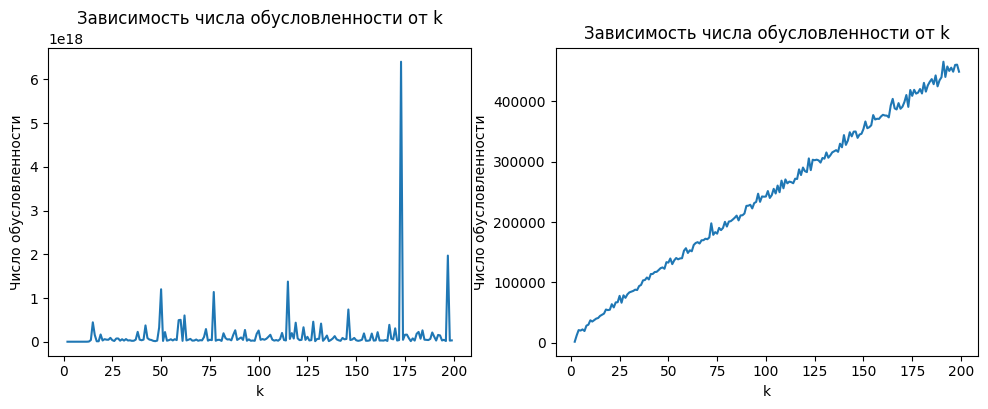

In [ ]:
k_values = range(2, 200)

# Вычисляем число обусловленности для каждого значения k (4)
cond_numbers_1 = []
for k in k_values:
    A = generate_system_matrix(k)
    while np.linalg.det(A) == 0:
      A = generate_system_matrix(k)
    b = generate_free_members(A)
    cond_numbers_1.append(np.linalg.cond(A))

cond_numbers_2 = []
for k in k_values:
    A = generate_system_matrix(k, 1e-3)
    while np.linalg.det(A) == 0:
      A = generate_system_matrix(k, 1e-3)
    b = generate_free_members(A)
    cond_numbers_2.append(np.linalg.cond(A))

# Строим графики зависимости числа обусловленности от k (4)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(k_values, cond_numbers_1)
ax[0].set_xlabel('k')
ax[0].set_ylabel('Число обусловленности')
ax[0].set_title('Зависимость числа обусловленности от k')

ax[1].plot(k_values, cond_numbers_2)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Число обусловленности')
ax[1].set_title('Зависимость числа обусловленности от k')

plt.show()

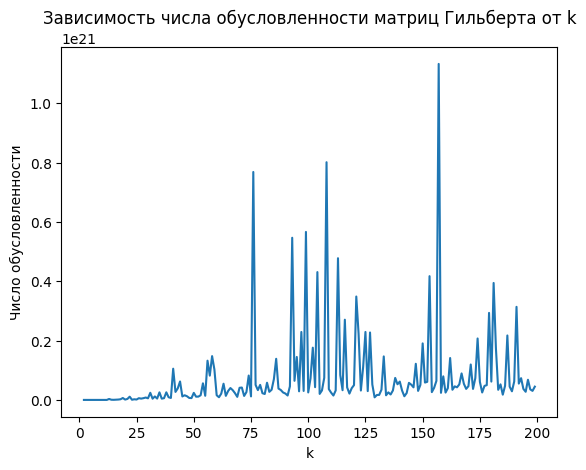

In [ ]:
k_values = range(2, 200)

# Вычисляем число обусловленности для каждого значения k (6)
cond_numbers = []
for k in k_values:
    A = generate_hilbert_matrix(k)
    b = generate_free_members(A)
    cond_numbers.append(np.linalg.cond(A))

plt.plot(k_values, cond_numbers)
plt.xlabel('k')
plt.ylabel('Число обусловленности')
plt.title('Зависимость числа обусловленности матриц Гильберта от k')
plt.show()

Функции для оценки точности полученного решения

In [ ]:
def residual(A, x, b):
    return b - np.dot(A, x)


def relative_residual(A, x, b):
    r = residual(A, x, b)
    return np.linalg.norm(r) / np.linalg.norm(b)


def solution_accuracy(A, x, b, x_exact):
    r = residual(A, x, b)
    r_exact = x - x_exact
    return np.linalg.norm(r_exact) / np.linalg.norm(x_exact)

Тестирование

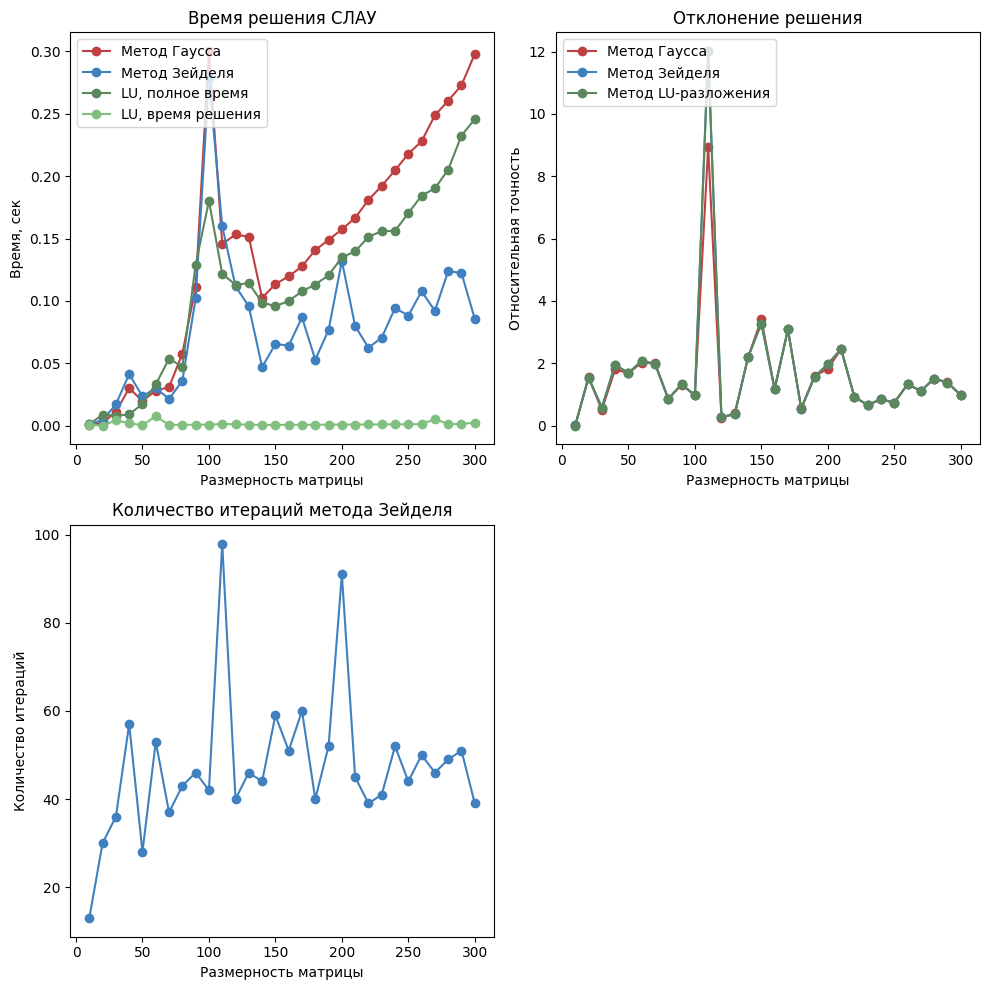

In [ ]:
k_values = range(10, 301, 10)

red = (0.75, 0.25, 0.25)
blue = (0.25, 0.5, 0.75)
green = (0.5, 0.75, 0.5)
dark_green = (91/255, 135/255, 93/255)

# Списки для времени и точности решения
gauss_time, seidel_time, lu_full_time, lu_time = [], [], [], []
seidel_iterations = []
gauss_accuracy, seidel_accuracy, lu_accuracy = [], [], []

for k in k_values:
    A = generate_system_matrix(k)
    while np.linalg.det(A) == 0:
        A = generate_system_matrix(k)
    b = generate_free_members(A)
    x_exact = range(1, k + 1)

    # Решение методом Гаусса
    start_time = time.time()
    x = gauss_solve(A, b)
    end_time = time.time()
    gauss_time.append(end_time - start_time)

    accuracy = solution_accuracy(A, x, b, x_exact)
    gauss_accuracy.append(accuracy)

    # Решение методом Зейделя
    start_time = time.time()
    x, iters = seidel_solve(A, b, eps=1e-10)
    end_time = time.time()
    seidel_time.append(end_time - start_time)

    accuracy = solution_accuracy(A, x, b, x_exact)
    seidel_accuracy.append(accuracy)

    seidel_iterations.append(iters)

    # Решение методом LU-разложения
    a = MatrixCSR(A)
    start_time = time.time()
    l, u = a.lu()
    mid_time = time.time()
    x = lu_solve(l, u, b)
    end_time = time.time()
    lu_full_time.append(end_time - start_time)
    lu_time.append(end_time - mid_time)

    accuracy = solution_accuracy(A, x, b, x_exact)
    lu_accuracy.append(accuracy)

plt.figure(figsize=(10, 10))

# График времени решения
plt.subplot(2, 2, 1)
plt.plot(k_values, gauss_time, marker='o', color=red, label='Метод Гаусса')
plt.plot(k_values, seidel_time, marker='o', color=blue, label='Метод Зейделя')
plt.plot(k_values, lu_full_time, marker='o', color=dark_green, label='LU, полное время')
plt.plot(k_values, lu_time, marker='o', color=green, label='LU, время решения')
plt.xlabel('Размерность матрицы')
plt.ylabel('Время, сек')
plt.title('Время решения СЛАУ')
plt.legend(loc='upper left')

# График точности решения
plt.subplot(2, 2, 2)
plt.plot(k_values, gauss_accuracy, marker='o', color=red, label='Метод Гаусса')
plt.plot(k_values, seidel_accuracy, marker='o', color=blue, label='Метод Зейделя')
plt.plot(k_values, lu_accuracy, marker='o', color=dark_green, label='Метод LU-разложения')
plt.xlabel('Размерность матрицы')
plt.ylabel('Относительная точность')
plt.title('Отклонение решения')
plt.legend(loc='upper left')

# График количества итераций метода Зейделя

plt.subplot(2, 2, 3)
plt.plot(k_values, seidel_iterations, marker='o', color=blue)
plt.xlabel('Размерность матрицы')
plt.ylabel('Количество итераций')
plt.title('Количество итераций метода Зейделя')

plt.tight_layout()
plt.show()

<ipython-input-6-4573d0756cfd>:15: RuntimeWarning: invalid value encountered in double_scalars
  norm_diff = abs(norm - norm_prev)


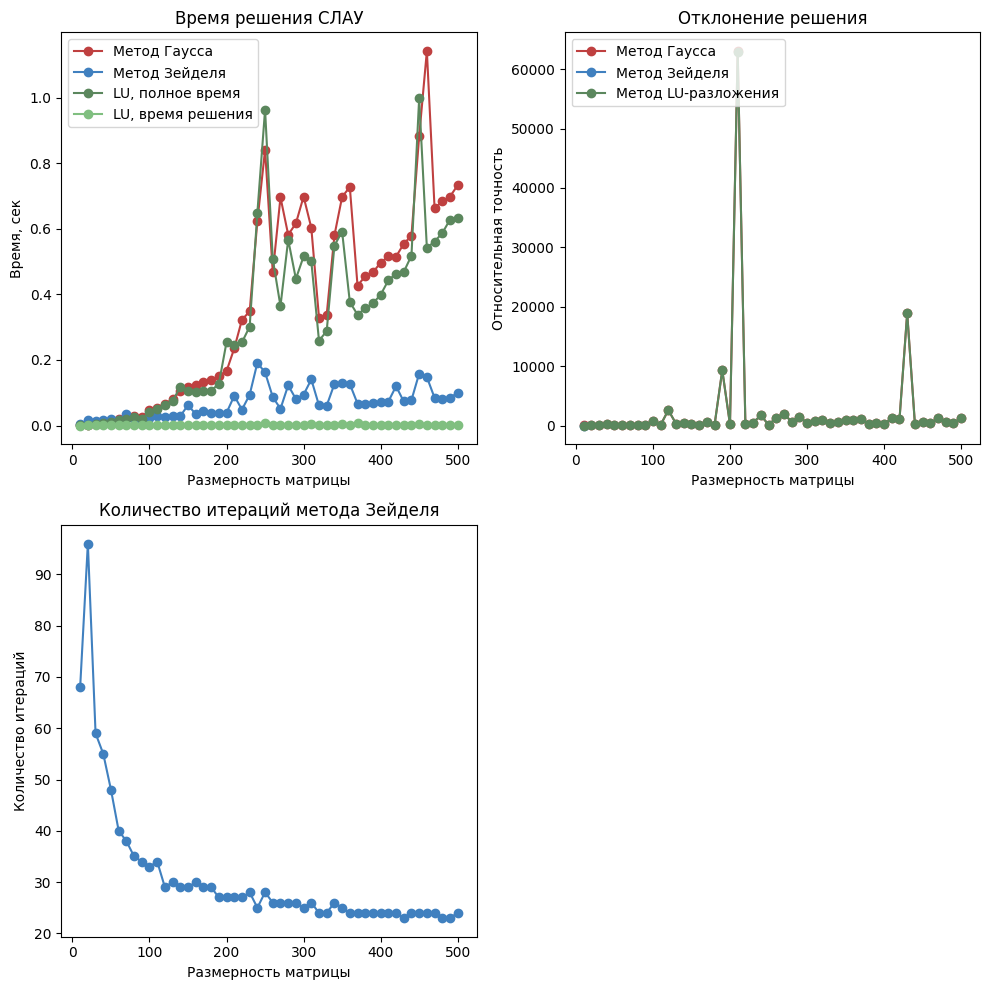

In [ ]:
gauss_time, seidel_time, lu_full_time, lu_time = [], [], [], []
seidel_iterations = []
gauss_accuracy, seidel_accuracy, lu_accuracy = [], [], []

for k in k_values:
    A = generate_hilbert_matrix(k)
    b = generate_free_members(A)
    x_exact = range(1, k + 1)

    # Решение методом Гаусса
    start_time = time.time()
    x = gauss_solve(A, b)
    end_time = time.time()
    gauss_time.append(end_time - start_time)

    accuracy = solution_accuracy(A, x, b, x_exact)
    gauss_accuracy.append(accuracy)

    # Решение методом Зейделя
    start_time = time.time()
    x, iters = seidel_solve(A, b, eps=1e-10)
    end_time = time.time()
    seidel_time.append(end_time - start_time)

    accuracy = solution_accuracy(A, x, b, x_exact)
    seidel_accuracy.append(accuracy)

    seidel_iterations.append(iters)

    # Решение методом LU-разложения
    a = MatrixCSR(A)
    start_time = time.time()
    l, u = a.lu()
    mid_time = time.time()
    x = lu_solve(l, u, b)
    end_time = time.time()
    lu_full_time.append(end_time - start_time)
    lu_time.append(end_time - mid_time)

    accuracy = solution_accuracy(A, x, b, x_exact)
    lu_accuracy.append(accuracy)

plt.figure(figsize=(10, 10))

# График времени решения
plt.subplot(2, 2, 1)
plt.plot(k_values, gauss_time, marker='o', color=red, label='Метод Гаусса')
plt.plot(k_values, seidel_time, marker='o', color=blue, label='Метод Зейделя')
plt.plot(k_values, lu_full_time, marker='o', color=dark_green, label='LU, полное время')
plt.plot(k_values, lu_time, marker='o', color=green, label='LU, время решения')
plt.xlabel('Размерность матрицы')
plt.ylabel('Время, сек')
plt.title('Время решения СЛАУ')
plt.legend(loc='upper left')

# График точности решения
plt.subplot(2, 2, 2)
plt.plot(k_values, gauss_accuracy, marker='o', color=red, label='Метод Гаусса')
plt.plot(k_values, seidel_accuracy, marker='o', color=blue, label='Метод Зейделя')
plt.plot(k_values, lu_accuracy, marker='o', color=dark_green, label='Метод LU-разложения')
plt.xlabel('Размерность матрицы')
plt.ylabel('Относительная точность')
plt.title('Отклонение решения')
plt.legend(loc='upper left')

# График количества итераций метода Зейделя

plt.subplot(2, 2, 3)
plt.plot(k_values, seidel_iterations, marker='o', color=blue)
plt.xlabel('Размерность матрицы')
plt.ylabel('Количество итераций')
plt.title('Количество итераций метода Зейделя')

plt.tight_layout()
plt.show()